In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


#### Power Conference Feature

From EDA we know that a small number of conferences account for 70% of all confernece wins. 

If one of the two teams is in a power conference, indicate the advantage that team has for winning the game.

In [3]:
# Compare the conferences of two teams playing in a game.
# If both teams are in power conference or both teams are not in a power conference return 0.
# If the opponent team is in a power conference and the first team is not in a power conference return -1
# If the first team is a power conference team and opponent is not then return 1.

def conf_compare(team_conf, opp_conf):
    team_top = team_conf in top_tournament_conferences_list
    opp_top = opp_conf in top_tournament_conferences_list
    if team_top == opp_top:
        return 0
    elif team_top :
        return 1
    else:
        return -1

In [4]:
def join_feature_name_with_importance_value(features, importances):
    """
    Join via a list of tuples, feature names with their importance values
    :param features: data frame whose features are represented by columns used by classifier
    :param importances: feature importance scores assigned by classifier
    :return: sorted list (highest importances first) of feature,importance tuples
    """
    if features.columns.shape[0] != importances.shape[0]:
        return []

    feature_importances = []
    for item in range(features.columns.shape[0]):
        feature_importances.append((features.columns[item], importances[item]))
    feature_importances_sorted = sorted(feature_importances, reverse=True, key=lambda kv: abs(kv[1]))

    return feature_importances_sorted


In [5]:
def display_important_features_regression(classifier, features):
    importances = classifier.coef_[0]
    #print("Importances: ", importances) 
    feature_importances = join_feature_name_with_importance_value(features, importances)
    print('Coefficient Values')
    for items in feature_importances:
        print(items[0]," ", items[1])

In [6]:
def get_tournament_record(df, season, round_, team):
    return df[(df['season_t'] == season) & (df['round']== round_) & (df['team']==team)]


In [7]:
def print_game_info(df, season, round_, team):
    t_rec = get_tournament_record(df, season, round_, team)
    opp_team = t_rec['opp_team'].iloc[0]
    print('\t\t',team,'\t',opp_team)
    print('Seed','\t\t',"%6d"%t_rec['team_seed'].iloc[0],'\t',"%6d"%t_rec['opp_team_seed'].iloc[0])
    print('PPG','\t\t',"%6.2f"%t_rec['pts_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['pts_avg_o'].iloc[0])
    print('Allow PPG','\t',"%6.2f"%t_rec['opp_pts_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['opp_pts_avg_o'].iloc[0])
    print('Poss Avg','\t',"%6.2f"%t_rec['poss_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['poss_avg_o'].iloc[0])
    print('FG %','\t\t',"%6.2f"%(100*t_rec['fg_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['fg_pct_o'].iloc[0]))
    print('Allow FG %','\t',"%6.2f"%(100*t_rec['allow_fg_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['allow_fg_pct_o'].iloc[0]))
    print('Off Rb Avg','\t',"%6.2f"%t_rec['off_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['off_rebs_avg_o'].iloc[0])
    print('Allow Off Rb Avg',"%6.2f"%t_rec['allow_off_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['allow_off_rebs_avg_o'].iloc[0])
    print('Def Rb Avg','\t',"%6.2f"%t_rec['def_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['def_rebs_avg_o'].iloc[0])
    print('Allow Def Rb Avg',"%6.2f"%t_rec['allow_def_rebs_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['allow_def_rebs_avg_o'].iloc[0])  
    print('FT ATT Avg','\t',"%6.2f"%t_rec['ft_att_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['ft_att_avg_o'].iloc[0]) 
    print('Allow FT ATT Avg',"%6.2f"%t_rec['allow_ft_att_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['allow_ft_att_avg_o'].iloc[0])
    print('FT %','\t\t',"%6.2f"%(100*t_rec['ft_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['ft_pct_o'].iloc[0]))
    print('Turnover Avg','\t',"%6.2f"%t_rec['to_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['to_avg_o'].iloc[0])
    print('Takeaway Avg','\t',"%6.2f"%t_rec['steal_avg_t'].iloc[0],'\t',"%6.2f"%t_rec['steal_avg_o'].iloc[0])
    print('Win %','\t\t',"%6.2f"%(100*t_rec['win_pct_t'].iloc[0]),'\t',"%6.2f"%(100*t_rec['win_pct_o'].iloc[0]))
    print('Off Rating','\t',"%6.2f"%t_rec['off_rating_t'].iloc[0],'\t',"%6.2f"%t_rec['off_rating_o'].iloc[0])
    print('\n\nTop Conference= ', t_rec['top_conf'].iloc[0])
    print('Game Result= ', t_rec['game_result'].iloc[0], ' (One indicates win for ', team,')')
    print('Predicted Result= ', t_rec['predicted_result'].iloc[0])
    print('Predicted Probability= ',"%6.3f"%t_rec['pred_win_prob'].iloc[0])
    return

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [8]:
#Note season indicates start of season, e.g. 2013 to 2014, the corresponding tournament season is 1 greater than this value
# The tournament season for season 2013 is 2014
summary_data = pd.read_csv('sr_summaries_kaggle_id.csv')
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]


(2439, 22)


,season,School,team_id,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,allow_fg_pct,ft_pct,allow_ft_att_avg,poss_avg,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg


In [9]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)


(2439, 22)


#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [10]:
# Read table of team names and associated team meta data
teams = pd.read_csv('D1_teams.csv')
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [11]:
tourney_data = pd.read_csv('tournament_results.csv')
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)

tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 9 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
dtypes: int64(4), object(5)
memory usage: 148.9+ KB


### Extract some historical data

In [12]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,431,20.358999,20.358999
9,Big Ten,313,14.785073,35.144072
24,Southeastern,269,12.706660,47.850732
5,Big 12,231,10.911667,58.762400
22,Pacific 12,197,9.305621,68.068021


Identify the conferences that have won 70% of all conference games

In [13]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

In [14]:
tourney_data.describe()['season']

count    2117.000000
mean     2001.193198
std         9.563883
min      1985.000000
25%      1993.000000
50%      2001.000000
75%      2010.000000
max      2017.000000
Name: season, dtype: float64

Note the tournament data is available for tournament years 1985 through 2017.

In [15]:
summary_data.describe()['season']

count    2439.000000
mean     2013.015990
std         1.997987
min      2010.000000
25%      2011.000000
50%      2013.000000
75%      2015.000000
max      2016.000000
Name: season, dtype: float64

The summary season data in this set goes back to 2010. If more training data is needed we can go back to earlier seasons.

So the intersection of season summary data with tournament data are regular seasons 2010 through 2016.

In [16]:
tourney_data = tourney_data[tourney_data['season'] >= 2011]
tourney_data.describe()['season']

count     469.000000
mean     2014.000000
std         2.002136
min      2011.000000
25%      2012.000000
50%      2014.000000
75%      2016.000000
max      2017.000000
Name: season, dtype: float64

In [17]:
tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469 entries, 10 to 2104
Data columns (total 9 columns):
season          469 non-null int64
round           469 non-null int64
game_date       469 non-null object
win_seed        469 non-null int64
win_market      469 non-null object
win_team_id     469 non-null object
lose_seed       469 non-null int64
lose_market     469 non-null object
lose_team_id    469 non-null object
dtypes: int64(4), object(5)
memory usage: 36.6+ KB


In [18]:
tourney_data.head()

,season,round,game_date,win_seed,win_market,win_team_id,lose_seed,lose_market,lose_team_id
10,2013,64,2013-03-22,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b
27,2013,64,2013-03-21,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5
30,2011,8,2011-03-27,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952


In [19]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1
tourney_data


,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,game_result,start_season
10,2013,64,2013-03-22,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,1,2012
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010
27,2013,64,2013-03-21,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,1,2012
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011
30,2011,8,2011-03-27,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,1,2010
31,2011,16,2011-03-25,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,10,Florida State,d3c8a767-b6fc-45d4-a5f2-18406f2993f1,1,2010
33,2011,32,2011-03-20,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,3,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,1,2010
34,2011,64,2011-03-18,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,1,2010
35,2011,68,2011-03-16,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,11,USC,3a000455-de7c-4ca8-880e-abdce7f21da9,1,2010
36,2016,64,2016-03-18,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,2015


In [20]:
# We need to recode the game data so that we have representation of the losing game result class.
# Swap the team and opp team data on the odd rows and reverse the sense of the game result.

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.head()

,season,round,game_date,team_seed,team,team_id,opp_team_seed,opp_team,opp_team_id,game_result,start_season
10,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,2012
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010
27,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2012
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011
30,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2010


In [21]:

tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
#tourney_data.info()

In [22]:
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))
#tourney_data.info()

In [23]:
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,School_t,Games_t,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,School_o,team_id_o,Games_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,2012,North Carolina State,35,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,Temple,8598d1b6-106b-4083-a512-2e495729525a,34,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Temple,34,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,Penn State,4aebd148-8119-4875-954c-66779867989b,34,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2012,Akron,33,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,36,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Virginia Commonwealth,36,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,33,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2010,Kansas,38,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,40,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20


Incorporate additional features here.
Team conference, seeding deltas.

In [24]:
tourney_data = tourney_data.join(teams, on='team_id_t', how='left')


In [25]:
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,School_t,Games_t,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,School_o,team_id_o,Games_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,2012,North Carolina State,35,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,Temple,8598d1b6-106b-4083-a512-2e495729525a,34,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Temple,34,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,Penn State,4aebd148-8119-4875-954c-66779867989b,34,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2012,Akron,33,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,36,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Virginia Commonwealth,36,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,33,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2010,Kansas,38,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,40,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10


#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [26]:
print(top_tournament_conferences_list)
tourney_data['top_conf'] = tourney_data.apply(lambda row: conf_compare(row.conf_name_t, row.conf_name_o),axis=1)
tourney_data.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


,game_result,conf_name_t,conf_name_o,top_conf
0,0,Atlantic Coast,American Athletic,1
1,1,American Athletic,Big Ten,-1
2,0,Mid-American,Atlantic 10,0
3,1,Atlantic 10,American Athletic,0
4,0,Big 12,Atlantic 10,1
5,1,Atlantic 10,Atlantic Coast,-1
6,0,Big Ten,Atlantic 10,1
7,1,Atlantic 10,Big East,0
8,0,Pacific 12,Atlantic 10,1
9,1,Atlantic 10,Pacific 12,-1


In [27]:
# Upsets occur less than 30% of the time when seeding deltas are more than 6
tourney_data['upset_seed_threshold'] = tourney_data.apply(lambda row: abs(row.team_seed - row.opp_team_seed) > 6, axis=1).astype(int)
tourney_data.head()


,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,School_t,Games_t,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,School_o,team_id_o,Games_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,2012,North Carolina State,35,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,Temple,8598d1b6-106b-4083-a512-2e495729525a,34,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Temple,34,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,Penn State,4aebd148-8119-4875-954c-66779867989b,34,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2012,Akron,33,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,36,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Virginia Commonwealth,36,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,33,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2010,Kansas,38,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,40,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,1,1


In [28]:
numeric_feature_to_scale = ['pts_avg_t','opp_pts_avg_t',
                            'off_rebs_avg_t','allow_off_rebs_avg_t',
                            'def_rebs_avg_t','allow_def_rebs_avg_t',
                            'ft_att_avg_t','allow_ft_att_avg_t',
                            'to_avg_t','steal_avg_t',
                            'SRS_t','SOS_t',
                            'off_rating_t',
                            'pts_avg_o','opp_pts_avg_o',
                            'off_rebs_avg_o','allow_off_rebs_avg_o',
                            'def_rebs_avg_o','allow_def_rebs_avg_o',
                            'ft_att_avg_o','allow_ft_att_avg_o',
                            'to_avg_o','steal_avg_o',
                            'SRS_o','SOS_o',
                            'off_rating_o']

scaler =StandardScaler()
tourney_data[numeric_feature_to_scale] = scaler.fit_transform(tourney_data[numeric_feature_to_scale])
tourney_data.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,School_t,Games_t,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,School_o,team_id_o,Games_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,0,2012,North Carolina State,35,-0.007116,0.295521,0.686,0.762567,1.202634,0.496,0.419,0.681,-0.329309,78.434286,0.124199,1.486906,-0.728602,-0.586560,0.499238,-0.175949,0.515246,0.813407,2012,Temple,8598d1b6-106b-4083-a512-2e495729525a,34,-0.594452,-0.120888,0.706,-0.286178,0.476227,0.428,0.438,0.723,0.015550,77.494118,0.114672,-0.080050,-1.955229,1.759565,-0.937318,0.573192,-0.506838,-0.318450,Atlantic Coast,American Athletic,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Temple,34,-0.261355,-0.306070,0.765,-0.679546,-0.472304,0.447,0.435,0.698,0.399210,75.688235,0.124199,0.734631,0.124617,0.016722,-0.870016,-0.175949,-0.612197,-0.753279,2010,Penn State,4aebd148-8119-4875-954c-66779867989b,34,-0.270064,1.148510,0.559,-2.110890,-0.614351,0.439,0.434,0.724,1.109496,68.341176,-1.005772,-1.552344,-1.110844,0.595622,-0.937318,-1.583176,-0.652509,-1.800864,American Athletic,Big Ten,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2012,Akron,33,-0.808551,-1.134792,0.788,-0.473530,-0.472304,0.455,0.395,0.643,0.399210,78.884848,0.718581,-0.017644,-1.155212,-0.586560,1.183865,0.617513,-1.103889,-0.361607,2012,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,36,0.377392,-0.269153,0.750,0.524804,-0.178120,0.450,0.444,0.701,0.744847,81.044444,1.235117,0.656097,-2.377422,0.595622,-0.273266,3.448350,-0.333128,-1.059657,Mid-American,Atlantic 10,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Virginia Commonwealth,36,-0.720793,-1.042712,0.806,-1.091578,-1.100406,0.410,0.424,0.685,0.034950,76.305556,0.718581,-0.017644,-2.435041,1.223287,-0.185389,2.997900,-1.280184,-0.361607,2011,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,33,0.447281,-0.405233,0.818,0.727550,-0.614351,0.482,0.393,0.748,0.015550,77.496970,-0.445550,-0.816197,0.155734,-0.568322,0.390785,-0.145597,0.787506,-0.689054,Atlantic 10,American Athletic,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,0,2010,Kansas,38,1.255048,0.387601,0.921,1.586632,-0.053569,0.508,0.380,0.679,0.034950,80.126316,0.124199,-0.017644,1.404447,-0.586560,1.183865,0.617513,1.093971,0.421736,2010,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,40,-0.721042,-0.409295,0.700,-0.488924,0.258111,0.434,0.424,0.715,0.015550,75.240000,-0.445550,-0.080050,-1.110844,1.177593,-0.273266,1.291982,-0.214904,-0.318450,Big 12,Atlantic 10,1,1


In [29]:

feature_data = tourney_data.drop(columns=['season_t','round','game_date','team','team_id_t',
                                         'opp_team','opp_team_id','game_result','start_season',
                                         'season_o','team_id_o','Games_t','Games_o',
                                          'School_o','School_t',
                                         'conf_name_t','conf_name_o']).copy()
feature_data.head()

,team_seed,opp_team_seed,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,top_conf,upset_seed_threshold
0,8,9,-0.007116,0.295521,0.686,0.762567,1.202634,0.496,0.419,0.681,-0.329309,78.434286,0.124199,1.486906,-0.728602,-0.586560,0.499238,-0.175949,0.515246,0.813407,-0.594452,-0.120888,0.706,-0.286178,0.476227,0.428,0.438,0.723,0.015550,77.494118,0.114672,-0.080050,-1.955229,1.759565,-0.937318,0.573192,-0.506838,-0.318450,1,0
1,7,10,-0.261355,-0.306070,0.765,-0.679546,-0.472304,0.447,0.435,0.698,0.399210,75.688235,0.124199,0.734631,0.124617,0.016722,-0.870016,-0.175949,-0.612197,-0.753279,-0.270064,1.148510,0.559,-2.110890,-0.614351,0.439,0.434,0.724,1.109496,68.341176,-1.005772,-1.552344,-1.110844,0.595622,-0.937318,-1.583176,-0.652509,-1.800864,-1,0
2,12,5,-0.808551,-1.134792,0.788,-0.473530,-0.472304,0.455,0.395,0.643,0.399210,78.884848,0.718581,-0.017644,-1.155212,-0.586560,1.183865,0.617513,-1.103889,-0.361607,0.377392,-0.269153,0.750,0.524804,-0.178120,0.450,0.444,0.701,0.744847,81.044444,1.235117,0.656097,-2.377422,0.595622,-0.273266,3.448350,-0.333128,-1.059657,0,1
3,12,5,-0.720793,-1.042712,0.806,-1.091578,-1.100406,0.410,0.424,0.685,0.034950,76.305556,0.718581,-0.017644,-2.435041,1.223287,-0.185389,2.997900,-1.280184,-0.361607,0.447281,-0.405233,0.818,0.727550,-0.614351,0.482,0.393,0.748,0.015550,77.496970,-0.445550,-0.816197,0.155734,-0.568322,0.390785,-0.145597,0.787506,-0.689054,0,1
4,1,11,1.255048,0.387601,0.921,1.586632,-0.053569,0.508,0.380,0.679,0.034950,80.126316,0.124199,-0.017644,1.404447,-0.586560,1.183865,0.617513,1.093971,0.421736,-0.721042,-0.409295,0.700,-0.488924,0.258111,0.434,0.424,0.715,0.015550,75.240000,-0.445550,-0.080050,-1.110844,1.177593,-0.273266,1.291982,-0.214904,-0.318450,1,1


In [30]:
X= feature_data
y= tourney_data['game_result']


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(375, 40)
(375,)
(94, 40)
(94,)


,team_seed,opp_team_seed,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,top_conf,upset_seed_threshold
212,16,1,-2.078459,-1.638164,0.583,-1.709626,-0.053569,0.421,0.428,0.699,0.763470,72.988889,-0.470183,-0.017644,-2.008432,1.223287,-0.185389,0.617513,-1.292228,-0.753279,1.433630,0.524982,0.806,0.930296,-0.614351,0.482,0.390,0.743,-1.078396,77.822222,0.674895,0.656097,-0.266458,-1.732266,1.054837,0.573192,0.962078,1.534567,-1,1
191,2,15,0.870462,-0.123956,0.921,0.968583,-0.681671,0.520,0.390,0.691,-0.329309,73.747368,-0.470183,-0.017644,1.404447,-1.793125,-0.870016,-0.969411,2.021053,0.030064,-2.076613,-1.914293,0.697,-1.908144,-0.614351,0.434,0.421,0.692,-1.078396,69.200000,-1.565994,-2.288490,0.155734,1.177593,-1.601369,-1.583176,-0.592090,-1.059657,0,1
263,3,14,0.550404,0.987145,0.750,-1.091578,-1.100406,0.459,0.390,0.714,-0.329309,74.833333,0.124199,-0.769919,-0.728602,-1.189843,1.183865,1.410976,-0.932595,-0.753279,-0.906972,-1.406534,0.765,-0.488924,-0.614351,0.484,0.415,0.731,0.380199,72.652941,-1.565994,-0.816197,-1.533036,-1.732266,1.718888,-0.145597,0.459558,-0.318450,1,1
466,2,15,0.345206,0.547206,0.794,0.762567,0.783900,0.456,0.433,0.701,0.399210,78.694118,0.124199,0.734631,-1.155212,0.016722,0.499238,-0.175949,0.450982,1.596750,-1.286743,-2.220979,0.771,0.322059,0.039996,0.444,0.414,0.768,0.015550,77.948571,0.114672,-0.080050,-1.533036,0.595622,-0.273266,0.573192,0.156951,0.052153,1,1
241,14,3,-1.149258,-1.587008,0.714,-0.473530,-0.472304,0.480,0.388,0.725,0.763470,72.331429,-1.064564,0.734631,-0.728602,-0.586560,-0.870016,2.204438,0.512849,-0.361607,0.503983,0.717930,0.706,-0.894415,-1.050583,0.434,0.402,0.674,-0.349099,76.388235,1.795339,0.656097,0.155734,-1.732266,0.390785,0.573192,-1.025149,0.052153,-1,1


In [35]:
logreg = LogisticRegression()

result = logreg.fit(X_train,y_train)

print("Coeffs ",logreg.coef_)
print("Intercept ", logreg.intercept_)

Coeffs  [[ 0.03474719 -0.11768226  0.80759762  0.50176652  1.35671918 -0.12996518
   0.04604274  0.01222078 -0.02695484 -0.11224932 -0.10468778  0.10423423
  -0.18666109  0.10435803 -0.14620709 -0.38534042 -0.30921603  0.35622867
  -0.07580765 -0.30463719 -0.83919172 -0.86254888 -1.34762062  0.24723232
   0.42312077 -0.0440872   0.17159414  0.17709819  0.11007766 -0.09688961
   0.00182506  0.01833185  0.12011945  0.05851105  0.13877984 -0.24840486
  -0.5072312  -0.08336525 -0.35572818 -0.07816011]]
Intercept  [-0.02298398]


In [36]:
display_important_features_regression(logreg, X_train)

Coefficient Values
win_pct_t   1.356719176342476
win_pct_o   -1.3476206234673493
SOS_o   -0.862548881450642
SRS_o   -0.8391917226637765
SRS_t   0.8075976162175847
off_rating_o   -0.5072312019433552
SOS_t   0.5017665207885235
opp_pts_avg_o   0.4231207672588095
allow_def_rebs_avg_t   -0.3853404162028196
steal_avg_t   0.3562286722432552
top_conf   -0.35572817679859037
to_avg_t   -0.3092160321894241
ft_att_avg_t   -0.3046371910206148
steal_avg_o   -0.24840486335569822
pts_avg_o   0.2472323231533702
off_rebs_avg_t   -0.18666108518125424
ft_pct_o   0.17709818631080176
allow_fg_pct_o   0.17159414118211852
def_rebs_avg_t   -0.1462070949654248
to_avg_o   0.1387798437761147
pts_avg_t   -0.12996517829814017
def_rebs_avg_o   0.1201194515444096
opp_team_seed   -0.11768225785558979
ft_pct_t   -0.11224931990587954
allow_ft_att_avg_o   0.11007766439912413
allow_ft_att_avg_t   -0.10468777965822702
allow_off_rebs_avg_t   0.10435803018527542
poss_avg_t   0.10423423365942037
poss_avg_o   -0.09688961121458

In [37]:
y_pred = logreg.predict(X_test)
prediction_probabilities = logreg.predict_proba(X_test)
print("LR model prediction accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

LR model prediction accuracy is 0.74


In [38]:
print("Log loss= ",log_loss(y_test,logreg.predict_proba(X_test)))

Log loss=  0.5096740887983632


In [39]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[36,  9],
       [15, 34]], dtype=int64)

Text(0.5,257.44,'Predicted label')

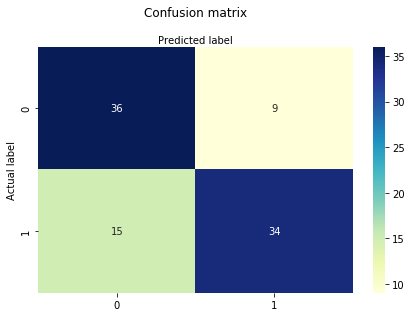

In [40]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [41]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.7446808510638298
Precision: 0.7906976744186046
Recall: 0.6938775510204082
Log loss=  0.5096740887983632


In [42]:
# Retrieve the non-normalized game stats
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_data[tourney_data.index.isin(X_test.index)].copy()

test_games[numeric_feature_to_scale] = scaler.inverse_transform(test_games[numeric_feature_to_scale])
test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs

test_games.head()

,season_t,round,game_date,team_seed,team,team_id_t,opp_team_seed,opp_team,opp_team_id,game_result,start_season,School_t,Games_t,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,School_o,team_id_o,Games_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,top_conf,upset_seed_threshold,predicted_result,pred_win_prob
9,2016,64,2016-03-18,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,7,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,1,2015,Virginia Commonwealth,36,13.83,4.35,0.694,77.0,67.0,0.451,0.440,0.692,20.0,81.427778,12.0,9.0,25.0,25.0,11.0,8.0,94.562325,20.0,2015,Oregon State,532d3874-b4b3-4c5c-acc6-749a6db26c8f,32,10.39,9.26,0.594,71.0,70.0,0.440,0.428,0.671,21.0,77.462500,10.0,11.0,23.0,25.0,11.0,7.0,91.657254,21.0,Atlantic 10,Pacific 12,-1,0,1,0.723467
21,2014,32,2014-03-23,6,Baylor,db6e1cab-3fa3-4a93-a673-8b2a358ff4bf,3,Creighton,7d797407-623e-476d-b299-46de4275414d,1,2013,Baylor,38,15.80,10.11,0.684,74.0,67.0,0.455,0.425,0.680,18.0,77.042105,13.0,11.0,24.0,20.0,11.0,5.0,96.051373,24.0,2013,Creighton,7d797407-623e-476d-b299-46de4275414d,35,18.03,7.17,0.771,78.0,67.0,0.497,0.426,0.743,18.0,72.302857,8.0,9.0,25.0,21.0,9.0,3.0,107.879554,18.0,Big 12,Big East,1,0,0,0.411513
34,2016,64,2016-03-18,16,Holy Cross,31aedd91-a77e-46c1-8bdc-80e9860c159d,1,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,0,2015,Holy Cross,35,-11.20,-6.11,0.429,64.0,69.0,0.412,0.459,0.687,17.0,72.462857,7.0,9.0,22.0,26.0,11.0,6.0,88.321110,19.0,2015,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,38,18.05,8.64,0.816,78.0,68.0,0.467,0.423,0.715,18.0,79.563158,11.0,10.0,24.0,22.0,11.0,7.0,98.035324,23.0,Patriot League,Pacific 12,-1,1,0,0.010930
40,2016,64,2016-03-18,9,Cincinnati,a17dfc54-415f-49c3-a2e6-d6fa9db18b0a,8,Saint Joseph's (PA),f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8,0,2015,Cincinnati,33,15.19,5.25,0.667,73.0,63.0,0.430,0.393,0.705,15.0,78.975758,13.0,11.0,25.0,23.0,11.0,7.0,92.433428,19.0,2015,Saint Joseph's,f9e4261e-d11d-46c4-bd33-c7bbc94ef0e8,36,12.10,4.93,0.778,77.0,70.0,0.453,0.417,0.716,15.0,78.622222,9.0,9.0,28.0,25.0,9.0,5.0,97.936687,22.0,American Athletic,Atlantic 10,0,0,1,0.738169
43,2012,64,2012-03-15,5,New Mexico,1b1977ec-b32f-4ce3-95a4-d07bab4816cd,12,Long Beach State,11a617d5-af03-4cce-bc8a-51114d9e41fe,1,2011,New Mexico,35,15.60,3.34,0.800,72.0,59.0,0.462,0.384,0.707,16.0,76.120000,11.0,10.0,23.0,21.0,13.0,6.0,94.587493,21.0,2011,Long Beach State,11a617d5-af03-4cce-bc8a-51114d9e41fe,34,9.52,0.87,0.735,73.0,63.0,0.468,0.421,0.670,15.0,77.529412,11.0,10.0,22.0,21.0,12.0,7.0,94.157815,23.0,Mountain West,Big West,0,1,0,0.484682


In [43]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
missed_predictions[['predicted_result','game_result','pred_win_prob','team','team_seed','conf_name_t', 'opp_team','opp_team_seed', 
                    'conf_name_o','top_conf','season_t','round']]


,predicted_result,game_result,pred_win_prob,team,team_seed,conf_name_t,opp_team,opp_team_seed,conf_name_o,top_conf,season_t,round
440,1,0,0.739623,Iowa State,5,Big 12,Purdue,4,Big Ten,0,2017,32
40,1,0,0.738169,Cincinnati,9,American Athletic,Saint Joseph's (PA),8,Atlantic 10,0,2016,64
170,1,0,0.689113,Syracuse,1,Atlantic Coast,Ohio State,2,Big Ten,0,2012,8
288,1,0,0.671038,Louisville,4,Atlantic Coast,Kentucky,8,Southeastern,0,2014,16
434,1,0,0.655885,West Virginia,3,Big 12,Stephen F. Austin,14,Southland,1,2016,64
138,1,0,0.646461,Kentucky,4,Southeastern,Connecticut,3,American Athletic,1,2011,4
182,1,0,0.556703,Virginia Commonwealth,11,Atlantic 10,Butler,8,Big East,0,2011,4
222,1,0,0.537464,North Carolina,8,Atlantic Coast,Kansas,1,Big 12,0,2013,32
444,1,0,0.530202,Clemson,12,Atlantic Coast,West Virginia,5,Big 12,0,2011,64
43,0,1,0.484682,New Mexico,5,Mountain West,Long Beach State,12,Big West,0,2012,64


In [44]:
print_game_info(test_games, 2017, 64, 'USC')

		 USC 	 SMU
Seed 		     11 	      6
PPG 		  78.00 	  74.00
Allow PPG 	  73.00 	  60.00
Poss Avg 	  79.22 	  73.98
FG % 		  45.60 	  47.30
Allow FG % 	  43.40 	  38.60
Off Rb Avg 	  10.00 	  11.00
Allow Off Rb Avg  11.00 	   9.00
Def Rb Avg 	  24.00 	  26.00
Allow Def Rb Avg  24.00 	  20.00
FT ATT Avg 	  21.00 	  19.00
Allow FT ATT Avg  14.00 	  13.00
FT % 		  74.10 	  69.70
Turnover Avg 	  11.00 	  10.00
Takeaway Avg 	   7.00 	   5.00
Win % 		  72.20 	  85.70
Off Rating 	  98.46 	 100.02


Top Conference=  1
Game Result=  1  (One indicates win for  USC )
Predicted Result=  0
Predicted Probability=   0.246


In [45]:
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

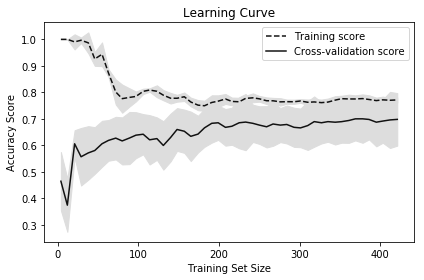

In [46]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [47]:
X.shape


(469, 40)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(200, max_features='sqrt',
                                                                   min_samples_split=10, min_samples_leaf=2,
                                                                   max_depth=10, random_state=0), 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

In [ ]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### Cross Validation Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score


In [ ]:
scores = cross_val_score(LogisticRegression(), X,y, cv=10, scoring='accuracy')
print(scores.mean())